In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score, hamming_loss, jaccard_score
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import pipeline
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.model_selection import GridSearchCV, train_test_split

from skmultilearn.adapt import MLkNN
from skmultilearn.problem_transform import LabelPowerset, BinaryRelevance, ClassifierChain

from scipy.sparse import lil_matrix

In [2]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 1000)

Import du dataset clean et mis en forme dans le précédent notebook

In [47]:
path = 'Saves/Dataset_cleaned&shaped.pkl'
df = pd.read_pickle(path)
df = df.sample(n=5000, random_state=42)

In [48]:
df.head()

,Tags,Corpus,.net,ajax,algorithm,arrays,asp.net,asp.net-mvc,c,c#,c++,cocoa,cocoa-touch,css,database,debugging,delphi,django,eclipse,git,html,iphone,java,javascript,jquery,linq,linux,macos,multithreading,mysql,objective-c,performance,perl,php,python,regex,ruby,ruby-on-rails,security,sql,sql-server,string,svn,unit-testing,vb.net,visual-studio,visual-studio-2008,wcf,windows,winforms,wpf,xml
92108,[unit-testing],unit testing database test crud operation unit...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
13874,[c#],mouse cursor programmaticallyto start http swi...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8228,[c#],reference desire overloaded generic method cor...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
84930,[sql-server],bad open close sql connection exact effect lot...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
74677,[c#],c xmldoc reference method overloadsif method p...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Import du multilabel_binarizer entrainé dans le notebook précédent

In [49]:
filename = 'Saves/multilabel_binarizer.pkl'
multilabel_binarizer = pickle.load(open(filename, 'rb'))

# 1. Constitution d'un jeu de données train & test

Il est à présent possible de couper en deux le dataset avec une partie servant d'apprentissage et l'autre au test du model. On utilise ici les variables Corpus et Tags pour les raisons définies précédemment.

In [50]:
train, test = train_test_split(df, test_size=0.33, random_state=42)
print("Length of train set : {}".format(len(train)))
print("Length of test set : {}".format(len(test)))

Length of train set : 3350
Length of test set : 1650


Il est maintenant possible de diviser chaque étape du dataset en 2 parties:

In [51]:
X_train, y_train = train.Corpus, train.drop(['Corpus', 'Tags'], axis=1)
X_test, y_test = test.Corpus, test.drop(['Corpus', 'Tags'], axis=1)

# 2. Représentation des données sous forme de sacs de mots (bag of words)

## 2.1. Création du Bag of Words

L'une des méthodes les plus simples, mais aussi les plus efficaces et les plus courantes, servant à transformer les textes afin de leur donner un format reconnaissable pour l'apprentissqge automatique, consiste à utiliser une représentation dites par sacs de mots (bag of words). Avec cette représentation, nous éliminons l'essentiel de la structure du texte présenté en entrée, comme les chapitres, les paragraphes, les phrases et tout ce qui concerne le formatage, et nous comptons uniquement le nombre d'apparitions de chaque mot dans chaque texte du corpus.

Calculer la représentation par sac de mots d'un corpus consiste à suivre une succession de trois étapes:
+ Tokenisation. Ce terme désigne le fait de partager un document dans les mots qui le composent, par exemple pour distinguer les espaces ou encore les signes de ponctuation. Un texte devient alors une séquence de tokens.
+ Construction du vocabulaire. Cela consiste à former un vocabulaire en collectant tous les mots qui apparaissent dans les documents afin de constituer un dictionnaire, et à les numéroter (par exemple dans l'ordre alphabétique).
+ Encodage. Pour chaque document, cette étape consiste à dénombrer le nombre d'occurence de chaque mot du vocabulaire.

Appliquons donc ces trois étapes sur notre jeu de données de stackoverflow.

In [52]:
print("X_train.shape : {}".format(X_train.shape))
print("X_test.shape : {}".format(X_test.shape))

X_train.shape : (3350,)
X_test.shape : (1650,)


In [53]:
custom_vectorizer = CountVectorizer(tokenizer=None, stop_words=None, min_df=5) 

In [54]:
custom_vectorizer.fit(X_train)
custom_vectorizer.fit(X_test)
X_train_BOW = custom_vectorizer.transform(X_train)
X_test_BOW = custom_vectorizer.transform(X_test)

In [55]:
filename = 'Saves/custom_vectorizer.pkl'
pickle.dump(custom_vectorizer, open(filename, 'wb'))

In [56]:
print("X_train_BOW.shape : {}".format(X_train_BOW.shape))
print("X_test_BOW.shape : {}".format(X_test_BOW.shape))

X_train_BOW.shape : (3350, 1566)
X_test_BOW.shape : (1650, 1566)


# Binary Relevance

In [15]:
br_classifier = BinaryRelevance(GaussianNB())
br_classifier.fit(X_train_BOW, y_train)
br_predictions = br_classifier.predict(X_test_BOW)

In [16]:
print("F1 score = {}".format(f1_score(y_test, br_predictions, average="samples")))
print("Jaccard score = {}".format(jaccard_score(y_test, br_predictions, average='samples')))
print("Hamming loss = {}".format(hamming_loss(y_test, br_predictions)))

F1 score = 0.22428824723312993
Jaccard score = 0.1583509477911398
Hamming loss = 0.19054501314990896


# K Neighbors

In [17]:
kn_classifier = KNeighborsClassifier()
kn_classifier.fit(X_train_BOW, y_train)
kn_predictions = kn_classifier.predict(X_test_BOW)

In [18]:
print("F1 score = {}".format(f1_score(y_test, kn_predictions, average="samples")))
print("Jaccard score = {}".format(jaccard_score(y_test, kn_predictions, average='samples')))
print("Hamming loss = {}".format(hamming_loss(y_test, kn_predictions)))

F1 score = 0.26487018679614266
Jaccard score = 0.23798300627149502
Hamming loss = 0.026638883269269675


# MLkNN

In [19]:
# to prevent errors when handling sparse matrices.
X_train_BOW_MLkNN = lil_matrix(X_train_BOW).toarray()
y_train_BOW_MLkNN = lil_matrix(y_train).toarray()
X_test_BOW_MLkNN = lil_matrix(X_test_BOW).toarray()

In [ ]:
ml_classifier = MLkNN(k=10)
ml_classifier.fit(X_train_BOW_MLkNN, y_train_BOW_MLkNN)
ml_predictions = ml_classifier.predict(X_test_BOW_MLkNN)

C:\Users\germa\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_neighbors=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [87]:
print("F1 score = {}".format(f1_score(y_test, ml_predictions, average="samples")))
print("Jaccard score = {}".format(jaccard_score(y_test, ml_predictions, average='samples')))
print("Hamming loss = {}".format(hamming_loss(y_test, ml_predictions)))

F1 score = 0.2386060606060606
Jaccard score = 0.2146464646464646
Hamming loss = 0.02703030303030303


# Extra Trees

In [88]:
et_classifier = ExtraTreesClassifier(n_estimators=50)
et_classifier = et_classifier.fit(X_train_BOW, y_train)
et_predictions = et_classifier.predict(X_test_BOW)

In [89]:
print("F1 score = {}".format(f1_score(y_test, et_predictions, average="samples")))
print("Jaccard score = {}".format(jaccard_score(y_test, et_predictions, average='samples')))
print("Hamming loss = {}".format(hamming_loss(y_test, et_predictions)))

F1 score = 0.3472424242424243
Jaccard score = 0.3227777777777777
Hamming loss = 0.022006060606060605


# Random Forest

In [90]:
rf_classifier = RandomForestClassifier(n_estimators=50)
rf_classifier = rf_classifier.fit(X_train_BOW, y_train)
rf_predictions = rf_classifier.predict(X_test_BOW)

In [91]:
print("F1 score = {}".format(f1_score(y_test, rf_predictions, average="samples")))
print("Jaccard score = {}".format(jaccard_score(y_test, rf_predictions, average='samples')))
print("Hamming loss = {}".format(hamming_loss(y_test, rf_predictions)))

F1 score = 0.38699999999999996
Jaccard score = 0.35926767676767674
Hamming loss = 0.021757575757575757


# Label Powerset

In [92]:
lp_classifier = LabelPowerset(LogisticRegression())
lp_classifier.fit(X_train_BOW, y_train)
lp_predictions = lp_classifier.predict(X_test_BOW)

C:\Users\germa\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [93]:
print("F1 score = {}".format(f1_score(y_test, lp_predictions, average="samples")))
print("Jaccard score = {}".format(jaccard_score(y_test, lp_predictions, average='samples')))
print("Hamming loss = {}".format(hamming_loss(y_test, lp_predictions)))

F1 score = 0.5253910533910534
Jaccard score = 0.47862121212121206
Hamming loss = 0.02583030303030303


# Classifier Chain

In [94]:
#for the next classifier we need to remove from y-train, y-test categories which equal 0 for all train samples
selected_labels = y_train.columns[y_train.sum(axis=0, skipna=True) > 0].tolist()
y_train_CC = y_train.filter(selected_labels, axis=1)
y_test_CC = y_test.filter(selected_labels, axis=1)

cc_classifier = ClassifierChain(LogisticRegression())
cc_classifier.fit(X_train_BOW, y_train_CC)
cc_predictions_proba = cc_classifier.predict_proba(X_test_BOW)

C:\Users\germa\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\germa\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [95]:
#for plotting metrics as a function of threashold
th = []
f = []
jac = []
ham = []

for t in range (1,101): # threshold value
    y_pred_new = (cc_predictions_proba >= t/100).astype(int)
    th.append(t/100)
    f.append(f1_score(y_test_CC, y_pred_new, average="samples"))
    jac.append(jaccard_score(y_test_CC, y_pred_new, average='samples'))
    ham.append(hamming_loss(y_test_CC, y_pred_new))

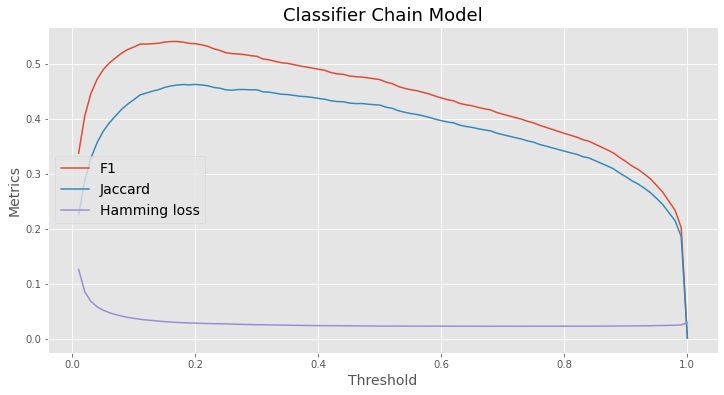

In [96]:
plt.rcParams["figure.figsize"] = (12, 6)

with plt.style.context('ggplot'):
    plt.plot(th, f)
    plt.plot(th, jac)
    plt.plot(th, ham)
    plt.legend(['F1', 'Jaccard', 'Hamming loss'], loc='center left', fontsize=14)
    plt.ylabel("Metrics", fontsize=14)
    plt.xlabel("Threshold", fontsize=14)
    plt.title("Classifier Chain Model", fontsize=18)

plt.show()

# Optimisation des meilleurs modèles supervisés

## Label Powerset

In [ ]:
parameters = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],
     'classifier__C' : np.logspace(-4, 4, 20),
     'classifier__solver' : ['liblinear']
    },
    {'classifier' : [RandomForestClassifier()],
     'classifier__n_estimators' : list(range(10,250,25)),
     'classifier__max_features' : list(range(5,40,5))
    }
]

scr = {'F1': 'f1_samples', 'Jaccard': 'jaccard_samples'}

clf = GridSearchCV(LabelPowerset(), parameters, scoring=scr, refit='F1', n_jobs=-1)
clf.fit(X_train_BOW, y_train)

print(clf.best_params_, clf.best_score_)

In [38]:
BEST_lp_classifier = LabelPowerset(RandomForestClassifier(max_features='log2', n_estimators=100, n_jobs=-1))
BEST_lp_classifier.fit(X_train_BOW, y_train)
BEST_lp_prediction = BEST_lp_classifier.predict(X_test_BOW)

In [39]:
print("F1 score = {}".format(f1_score(y_test, BEST_lp_prediction, average="samples")))
print("Jaccard score = {}".format(jaccard_score(y_test, BEST_lp_prediction, average='samples')))
print("Hamming loss = {}".format(hamming_loss(y_test, BEST_lp_prediction)))

F1 score = 0.5196767676767677
Jaccard score = 0.47570707070707074
Hamming loss = 0.02493333333333333


In [40]:
filename = 'Saves/lp_classifier.pkl'
pickle.dump(BEST_lp_classifier, open(filename, 'wb'))

## Chain Classifier

In [89]:
parameters = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],
     'classifier__C' : np.logspace(-4, 4, 20),
     'classifier__solver' : ['liblinear']
    },
    {'classifier' : [RandomForestClassifier()],
     'classifier__n_estimators' : list(range(10,101,10)),
     'classifier__max_features' : list(range(6,32,5))
    }
]

scr = {'F1': 'f1_samples', 'Jaccard': 'jaccard_samples'}

clf = GridSearchCV(ClassifierChain(), parameters, scoring=scr, refit='F1')
clf.fit(X_train_BOW, y_train)

print(clf.best_params_, clf.best_score_)

{'classifier': LogisticRegression(C=1.623776739188721, penalty='l1', solver='liblinear'), 'classifier__C': 1.623776739188721, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'} 0.5136651267472162


In [41]:
#for the next classifier we need to remove from y-train, y-test categories which equal 0 for all train samples
selected_labels = y_train.columns[y_train.sum(axis=0, skipna=True) > 0].tolist()
y_train_CC = y_train.filter(selected_labels, axis=1)
y_test_CC = y_test.filter(selected_labels, axis=1)

BEST_cc_classifier = ClassifierChain(LogisticRegression(C=1.623776739188721, penalty='l1', solver='liblinear'))
BEST_cc_classifier.fit(X_train_BOW, y_train_CC)
BEST_cc_predictions_proba = BEST_cc_classifier.predict_proba(X_test_BOW)

In [44]:
#for plotting metrics as a function of threashold
th = []
f = []
jac = []
ham = []

for t in range (1,101): # threshold value
    y_pred_new = (BEST_cc_predictions_proba >= t/100).astype(int)
    th.append(t/100)
    f.append(f1_score(y_test_CC, y_pred_new, average="samples"))
    jac.append(jaccard_score(y_test_CC, y_pred_new, average='samples'))
    ham.append(hamming_loss(y_test_CC, y_pred_new))

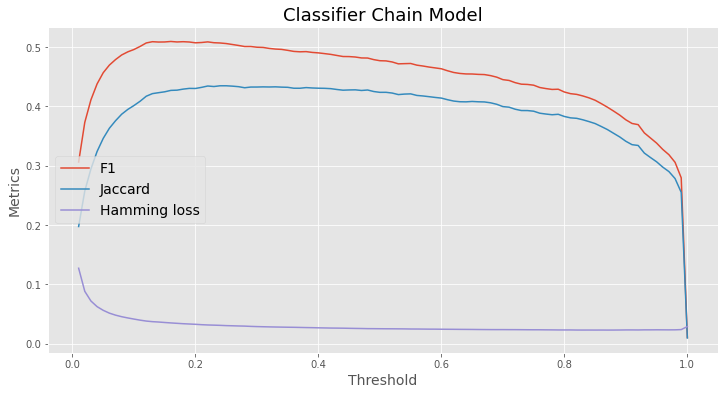

In [45]:
plt.rcParams["figure.figsize"] = (12, 6)

with plt.style.context('ggplot'):
    plt.plot(th, f)
    plt.plot(th, jac)
    plt.plot(th, ham)
    plt.legend(['F1', 'Jaccard', 'Hamming loss'], loc='center left', fontsize=14)
    plt.ylabel("Metrics", fontsize=14)
    plt.xlabel("Threshold", fontsize=14)
    plt.title("Classifier Chain Model", fontsize=18)

plt.show()

In [46]:
filename = 'Saves/cc_classifier.pkl'
pickle.dump(BEST_cc_classifier, open(filename, 'wb'))

# Prédiction semi-supervisée

Maintenant que les tests de prédiction non-supervisé et supervisés ont été menés à bien, il s'agit de selectionner les meilleurs et les combiner. Voici les modèles retenus:
- Label Powerset en prédiction supervisée
- Classifier Chain en prédiction supervisée
- LDA en prédiction non-supervisée

## LDA

In [134]:
lda = LatentDirichletAllocation(learning_method="batch", max_iter=25, random_state=42)

In [135]:
pip = pipeline.Pipeline(steps=[("lda", lda), ("classifier_chain", BEST_cc_classifier)])

In [136]:
param_grid = {
    'lda__n_components': list(range(0, 1001, 25))
}
scr = {'F1': 'f1_samples', 'Jaccard': 'jaccard_samples'}

In [137]:
search = GridSearchCV(pip, param_grid, scoring=scr, refit='F1', n_jobs=-1)

In [138]:
search.fit(X_train_BOW, y_train)

GridSearchCV(estimator=Pipeline(steps=[('lda',
                                        LatentDirichletAllocation(max_iter=25,
                                                                  random_state=42)),
                                       ('classifier_chain',
                                        ClassifierChain(classifier=LogisticRegression(C=1.623776739188721,
                                                                                      penalty='l1',
                                                                                      solver='liblinear'),
                                                        require_dense=[True,
                                                                       True]))]),
             n_jobs=-1,
             param_grid={'lda__n_components': [0, 25, 50, 75, 100, 125, 150,
                                               175, 200, 225, 250, 275, 300,
                                               325, 350, 375, 400, 425, 450,
 

In [139]:
print(search.best_params_, search.best_score_)

{'lda__n_components': 975} 0.3130536602700781


## NMF

In [141]:
nmf = NMF(max_iter=25, random_state=42)

In [142]:
pip_nmf = pipeline.Pipeline(steps=[("nmf", nmf), ("classifier_chain", BEST_cc_classifier)])

In [143]:
param_grid = {
    'nmf__n_components': list(range(0, 1001, 25))
}
scr = {'F1': 'f1_samples', 'Jaccard': 'jaccard_samples'}

In [144]:
search_nmf = GridSearchCV(pip_nmf, param_grid, scoring=scr, refit='F1', n_jobs=-1)

In [145]:
search_nmf.fit(X_train_BOW, y_train)

C:\Users\germa\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 25 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


GridSearchCV(estimator=Pipeline(steps=[('nmf',
                                        NMF(max_iter=25, random_state=42)),
                                       ('classifier_chain',
                                        ClassifierChain(classifier=LogisticRegression(C=1.623776739188721,
                                                                                      penalty='l1',
                                                                                      solver='liblinear'),
                                                        require_dense=[True,
                                                                       True]))]),
             n_jobs=-1,
             param_grid={'nmf__n_components': [0, 25, 50, 75, 100, 125, 150,
                                               175, 200, 225, 250, 275, 300,
                                               325, 350, 375, 400, 425, 450,
                                               475, 500, 525, 550, 575, 600,
            

In [146]:
print(search_nmf.best_params_, search_nmf.best_score_)

{'nmf__n_components': 725} 0.35269900497512435
